<a href="https://colab.research.google.com/github/raplima/one-mev-forecast/blob/master/1/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting Megaelectron‐Volt Electrons Inside Earth's Outer Radiation Belt With Machine Learning

Man‐made satellites operating in medium‐ and high‐altitude Earth orbits are continuously exposed to hazardous space radiation originated from different sources. A major contributor to such hazardous environment are the relativistic electron population trapped within Earth's outer Van Allen belt. Electrons are deemed relativistic when they contain energies comparable to and/or larger than their rest energy of 0.511 megaelectron‐volt (MeV). Due to their high penetration capability, these MeV electrons are difficult to be fully stopped by normal shielding. Given that the successful NASA Van Allen Probes mission, also known as RBSP [(Mauk et al., 2013)](https://link.springer.com/article/10.1007%2Fs11214-012-9908-y), ended in October 2019, the need of reliable forecasting models for MeV electrons becomes compelling once again due to the  absence of in situ measurements. 

In this notebook, we use a machine learning approach to forecast the fluxes of one MeV electrons in Earth's outer radiation belt using as input measurements of precipitating electrons together with upstream solar wind speeds. We use linear regression from the [Scikit-Learn](https://scikit-learn.org/stable/), as well as a model created with [TensorFlow](https://tensorflow.org/).

The analysis that follows is a small subset of the work published in Pires de Lima et al. (2020): [Forecasting Megaelectron‐Volt Electrons Inside Earth's Outer Radiation Belt: PreMevE 2.0 Based on Supervised Machine Learning Algorithms](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019SW002399). If you use any of this code, we ask that you cite [Pires de Lima et al. (2020)]((https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019SW002399)).

Here is a video that talks about the radiation belts:

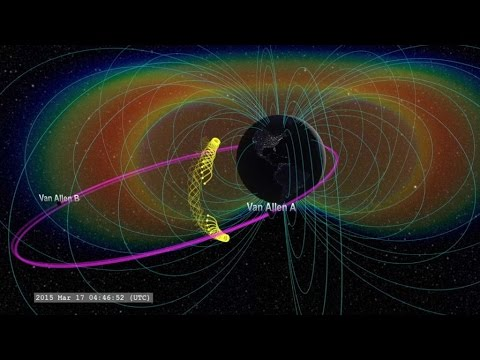

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("CKlho5eXuLQ")

To perform the forecasting analysis, we'll look at data from three main sources:
- OMNI 
 - This data set includes the geomagnetic disturbance index Dst and upstream solar wind conditions.
- POES 
 - These are measurements from low-Earth-orbit satellite POES-15 for electrons with different energies.
- RBSP 
 - RBSP measurements are the target of the model--the 1 MeV electrons.  

The [OMNI](https://omniweb.gsfc.nasa.gov/html/overview.html) data contains solar wind magnetic field and plasma measurements from spacecraft orbiting about the L1 Lagrange point $\sim$225 Re in front of the Earth. [POES](https://www.ospo.noaa.gov/Operations/POES/index.html) data contains the spatial distributions of >100 keV, >300 keV and >1000 kev electrons observed in low Earth orbit. [RBSP](https://www.nasa.gov/mission_pages/rbsp/mission/index.html) data contains the radial distributions of 1MeV electrons observed by RBSP-a. 

The data we will use for forecasting were prepared by Yue Chen at LANL and cover the time between February 20, 2013 and August 31, 2016. 

The next cell imports the necessary [files](https://drive.google.com/file/d/1jFqGyOX1CVQiBNGlO4ieLXMCfa4AkVS4/view?usp=sharing) for the analysis:

In [2]:
!wget https://osf.io/zf32y/download
!unzip download > /dev/null; mv example data
!ls data

--2020-09-16 01:26:18--  https://osf.io/zf32y/download
Resolving osf.io (osf.io)... 35.190.84.173
Connecting to osf.io (osf.io)|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://files.osf.io/v1/resources/p6ftmhwxa9/providers/osfstorage/5f5022d0154f9a00414eda10?action=download&direct&version=1 [following]
--2020-09-16 01:26:19--  https://files.osf.io/v1/resources/p6ftmhwxa9/providers/osfstorage/5f5022d0154f9a00414eda10?action=download&direct&version=1
Resolving files.osf.io (files.osf.io)... 35.186.214.196
Connecting to files.osf.io (files.osf.io)|35.186.214.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330283 (323K) [application/octet-stream]
Saving to: ‘download’

download            100%[===================>] 322.54K   765KB/s    in 0.4s    

2020-09-16 01:26:21 (765 KB/s) - ‘download’ saved [330283/330283]

Input_data_OMNI_20130220-20160831.txt
Input_data_POES_E2_100keV_electrons_20130220-20160831_exa

The cell above downloaded the files we need into a folder called `data`. Then, we listed the files in the `data` folder. The file naming convention helps us quickly see what are the targets and inputs, as well as the source of the data and the time span of the data present.

The next cell imports all the libraries we'll use in this notebook:

In [3]:
import os              # manage filepaths
import numpy as np     # manage with n-dimensional arrays
import pandas as pd    # manage tabular data

from matplotlib import pyplot as plt    # for most plots
import seaborn as sns                   # easier setup for some types of plots
import plotly.express as px             # for interactive plots

from sklearn.metrics import r2_score               # to measure models' performances
from sklearn.preprocessing import StandardScaler   # to scale data
from sklearn.linear_model import LinearRegression  # OLS linear model
import tensorflow as tf                            # CNN model

from timeit import default_timer as timer   # to measure this notebook execution time
start_time = timer()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Now that we downloaded the data and imported the necessary libraries, we can continue with the analysis.

# 1. Data Input and Visualization

The data was pre-processed and is now corrected and binned into five hours windows. Before we start with the analysis, let's check the files.  
Data from OMNI:



In [4]:
!head -n 15 data/Input_data_OMNI_20130220-20160831.txt

;Produced by Yue Chen, @LANL, on Jul  3, 2018
;======> All Rights Reserved; Please do not redistribute without author"permission <=====       
;
;Data used as inputs for forecasting models: OMNI data between 20130220 and 20160831
;Columns: S/N, Time (days in hr, counted from 20130220 00:00:00), Dst(nT), upstream solar wind speed (km/s), upstream solar wind proton density
;

;format (I5, 3x, f15.4, 3e15.2)

  S/N              Time            Dst      S/W speed     S/W p+ den
    1            0.1875      -3.50e+00       3.52e+02       9.00e+00
    2            0.3958      -3.50e+00       3.86e+02       6.95e+00
    3            0.6042      -1.85e+01       3.90e+02       6.00e+00
    4            0.8125      -1.30e+01       3.84e+02       6.60e+00
    5            1.0208      -1.20e+01       4.13e+02       9.20e+00


The head of the OMNI file shows that the file contains a header explaining the data that is organized in columns.  
Let's check the RBSP target data format:

In [5]:
!head -n 15 data/Target_data_RBSP_1MeV_electrons_20130220-20160831_example.txt

;Produced by Yue Chen, @LANL, on Jul  3, 2018 - Lshell selection performed by Rafael Pires de Lima, on August 12, 2020
;======> All Rights Reserved; Please do not redistribute without author"permission <=====       
;
;Data to be compared to model forecast results: Radial distributions of 1MeV electrons observed by RBSP-a between 20130220 and 20160831
;Columns: S/N, Time (days in hr, counted from 20130220 00:00:00), e- fluxes at L1/L2, .../Ln
;L values are shown in the top row

;format (I5, 3x, f10.4, 43e10.2)

  S/N         Time       4.00      4.10      4.20  
    1       0.1875   1.78e+00  2.59e+00  4.96e+00  
    2       0.3958   1.25e+00  1.95e+00  3.51e+00  
    3       0.6042   8.84e-01  1.46e+00  2.49e+00  
    4       0.8125   1.15e+00  1.83e+00  3.38e+00  
    5       1.0208   1.17e+00  1.91e+00  3.47e+00  


Much like the OMNI data, the RBSP data contains a header and the data is organized in columns. However, unlike the OMNI data that contains multiple information, the RBSP has only fluxes at different L-shells. Here, we see only L-shells 4.00, 4.10, and 4.20. The POES input has the same format, so we will not display the head of the files here.  

 To make file managing easier, we define a `dictionary` in the next cell:

In [6]:
data_dir = './data/'
dict_files = {'omni': os.path.join(data_dir, 'Input_data_OMNI_20130220-20160831.txt'), 
              'e2':   os.path.join(data_dir, 'Input_data_POES_E2_100keV_electrons_20130220-20160831_example.txt'), 
              'e3':   os.path.join(data_dir, 'Input_data_POES_E3_300keV_electrons_20130220-20160831_example.txt'), 
              'p6':   os.path.join(data_dir, 'Input_data_POES_P6_1000keV_electrons_20130220-20160831_example.txt'), 
              'rbsp': os.path.join(data_dir, 'Target_data_RBSP_1MeV_electrons_20130220-20160831_example.txt'), 
              }

Now it is much easier to access the files if we need to. For example, the address to the target data file:

In [7]:
print(dict_files['rbsp'])

./data/Target_data_RBSP_1MeV_electrons_20130220-20160831_example.txt


The fact that the files have been preprocessed help in the analysis as they have similar format, but we still need to read the data into Python. [Pandas](https://pandas.pydata.org/) is a very helpful library to work with data organized in columns, so we'll use it to manage the data. [Pandas](https://pandas.pydata.org/) main object for two-dimensional tabular data is called a `dataframe`.

We could read file by file into independent `dataframes` with something like:


```python
# read rbsp data 
df = pd.read_csv(dict_files['rbsp'])
```

But we will make use of the dictionary created before to help manage the files and read all the data using a single loop:



In [8]:
dfs = {}
for name in dict_files:
    if name == 'omni':
        # there are spaces in the omni columns names:
        dfs[name] = pd.read_csv(dict_files[name], 
                                skiprows=10, 
                                sep='\s+', 
                                header=None,
                                names=['S/N', 'Time', 'Dst', 'SWspeed', 'SWpden'])
        dfs[name] = dfs[name].set_index(['S/N', 'Time'])
        # the only column we keep is the solar wind speed:
        dfs[name] = dfs[name]['SWspeed']
    else:
        dfs[name] = pd.read_csv(dict_files[name], 
                                skiprows=9, 
                                sep='\s+', 
                                index_col=['S/N', 'Time'])

We can then concatenate all the `dataframes` stored in the `dictionaries` into a single `dataframe` with a `MultiIndex`:

In [9]:
df = pd.concat(dfs, axis=1)
df

omni      e2                ...     p6     rbsp                
               SWspeed    4.00   4.10   4.20  ...   4.20     4.00    4.10    4.20
S/N  Time                                     ...                                
1    0.1875      352.0   11.50   20.2   41.7  ...   4.13    1.780    2.59    4.96
2    0.3958      386.0    9.11   16.1   34.0  ...   3.32    1.250    1.95    3.51
3    0.6042      390.0    8.70   15.2   30.6  ...   3.01    0.884    1.46    2.49
4    0.8125      384.0    8.64   14.3   28.2  ...   2.90    1.150    1.83    3.38
5    1.0208      413.0    8.59   14.5   28.5  ...   2.72    1.170    1.91    3.47
...                ...     ...    ...    ...  ...    ...      ...     ...     ...
6183 1288.1042   426.0  367.00  482.0  597.0  ...  57.70   92.200  150.00  209.00
6184 1288.3125   458.0  431.00  570.0  713.0  ...  54.20  113.000  159.00  218.00
6185 1288.5208   425.0  485.00  643.0  797.0  ...  43.20   92.400  138.00  206.00
6186 1288.7292   412.0  538.00  710.0  882.0  ...  40.20  113.000  180.00  247.00
6187 1288.9375   426.0  596.00  778.0  959.0  ...  42.20   66.200  113.00  154.00

[6187 rows x 13 columns]

The output from the cell above shows the dataframe `df` organization. `S/N` and `Time` are the row indexes. `S/N` and `Time` are, respectively,  an integer marker and days in hours, counted from 00:00:00 February 20, 2013. The following columns contain the actual data we use in the analysis: `omni`, `e2`, `e3`, `p6`, and `rbsp`:
 - omni: solar wind speed in km/s
 - e2: < 100 keV electron fluxes 
 - e3: < 300 keV electron fluxes
 - p6: < 1000 keV electron fluxes
 - rbsp: 1MeV electron fluxes  

As `S/N` and `Time` represent the same thing, we drop one of the levels:

In [10]:
df = df.droplevel('S/N')

Now is a good opportunity to explore the data. We first start making a plot to see if there are any missing values:

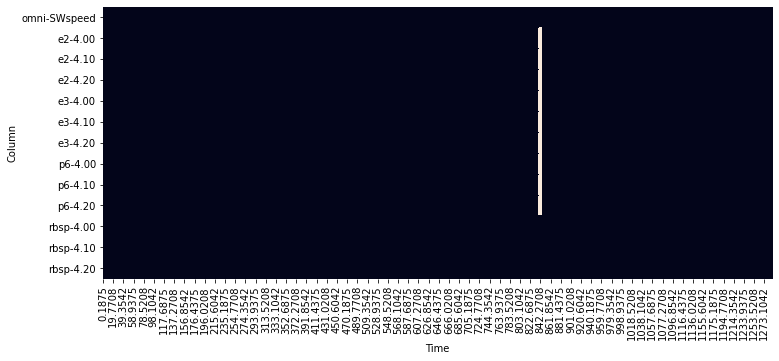

In [11]:
fig, ax = plt.subplots(1, figsize=(12,5))
sns.heatmap(df.isnull().T, cbar=False, ax=ax)
ax.set_ylabel('Column');

The figure depicting the null values in the dataframe (`df.isnull()`) above shows a white line around `Time` $\sim 840$. That is an indication that there are no measurements in that period.  

We can also plot the data for visualization:

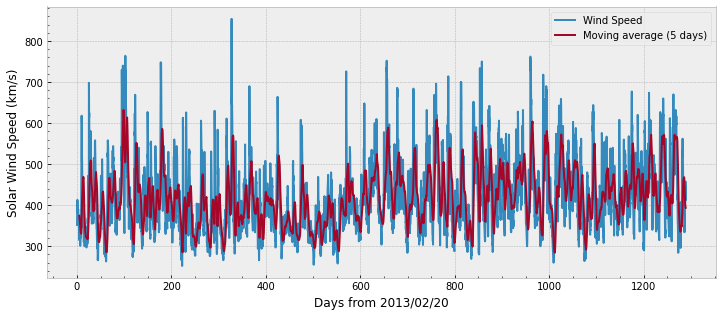

In [12]:
# plot OMNI with specific aesthetics:
with plt.style.context('bmh'):
    fig, ax = plt.subplots(1, figsize=(12,5))
    ax.plot(df.index.get_level_values('Time'), df['omni'], 
            label='Wind Speed')
    ax.plot(df.index.get_level_values('Time'), df['omni'].rolling(24).mean(), 
            label='Moving average (5 days)')
    ax.set_ylabel('Solar Wind Speed (km/s)')
    ax.set_xlabel('Days from 2013/02/20')
    ax.legend()
    ax.minorticks_on()

We can plot the remaining of the data in a single figure with the code below. Note that the range goes over 6,000 for E2, E3, and RBSP (the target), whereas P6 does not cross 1,000.

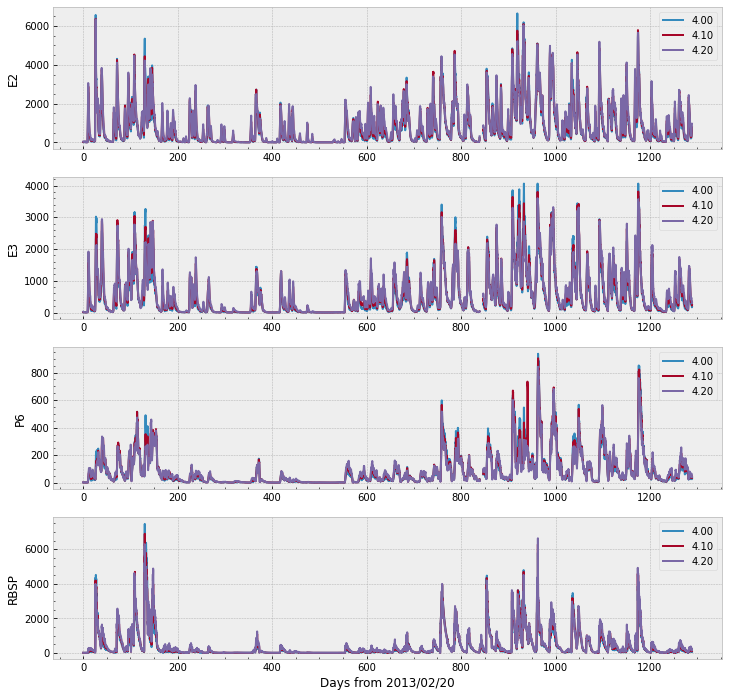

In [13]:
with plt.style.context('bmh'):
    fig, ax = plt.subplots(nrows=4, figsize=(12,12))
    for ii, source in enumerate(['e2', 'e3', 'p6', 'rbsp']):
        df[source].plot(ax=ax[ii]) # Pandas plot function
        ax[ii].minorticks_on()
        ax[ii].set_ylabel(source.upper())
        ax[ii].set_xlabel('')
    ax[-1].set_xlabel('Days from 2013/02/20')

It would be interesting to have some interactivity and to see all the data in a single plot. One possible approach is to [melt](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.melt.html) the dataframe to a long format and use [Plotly](https://plotly.com/). 

Let's first [melt](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.melt.html) the `dataframe`, discarding the OMNI data:

In [14]:
melted_df = df.drop('omni', axis=1).reset_index().melt(id_vars='Time', var_name = ['source', 'L-shell'])
melted_df

Time source L-shell   value
0         0.1875     e2    4.00   11.50
1         0.3958     e2    4.00    9.11
2         0.6042     e2    4.00    8.70
3         0.8125     e2    4.00    8.64
4         1.0208     e2    4.00    8.59
...          ...    ...     ...     ...
74239  1288.1042   rbsp    4.20  209.00
74240  1288.3125   rbsp    4.20  218.00
74241  1288.5208   rbsp    4.20  206.00
74242  1288.7292   rbsp    4.20  247.00
74243  1288.9375   rbsp    4.20  154.00

[74244 rows x 4 columns]

The next cell creates an interactive plot. You can zoom and pan to see the data. You can also select the data by clicking on the legend on the right.

In [15]:
fig = px.line(melted_df, x='Time', y='value', color='source', animation_frame='L-shell')
fig.show()

# 2. Data Preparation

In the previous section, we saw that there is a missing section in the data and that the flux of E2, E3, and RBSP can go over 6,000. 

In this section, we execute two common steps in machine learning projects: feature scaling and data split. 

The main objective of feature scaling is to adjust the magnitudes of the data. The rational is that the feature importance is not dependent on its magnitude, rather on their intrinsic relationship. Moreover, some algorithms such as gradient descent converge faster with feature scaling than without it. 

In machine learning applications, it is very important to understand whether the model is overfitting the data and how the model performs with unseen data. Thus, it is very common to split the data into three parts: the training set, the validation set, and the test set. 
The training set is the data effectively used to fit the model. The validation set is the data used during experiments to evaluate models' performance and to fine-tune hyperparameters. Finally, the test set is the data reserved from the start of the projects and ideally evaluated only during the final stages of the experiments. 

## 2.1 Data Split

We will make use of the region without information (around `Time` $\sim 840$) to set the `train`, `val`, and `test` sets:

Text(0.5, 0, 'Time')

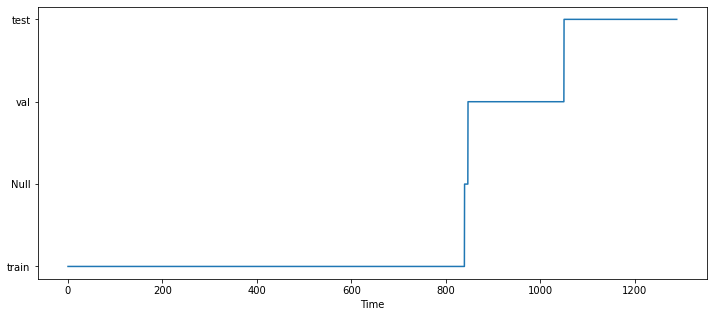

In [16]:
# create a new column that identifies the set:
df['set'] = 'train'
# the validation starts somewhere in the null zone:
df.loc[840:, 'set'] = 'val'
# let's set the final ~250 days to be part of the test:
df.loc[1050:, 'set'] = 'test'
# we have no information in the null zone, so we remove it from the analysis:
df = df.mask(df['e2']['4.00'].isnull())
# plot it to see the split:
fig, ax = plt.subplots(1, figsize=(12,5))
ax.plot(df.index, df['set'].fillna(value='Null'))
ax.set_xlabel('Time')

And if we print the data at that location, we can see that all columns have `NaN` (Null) values at the same period of time:

In [17]:
df.loc[839:839.6]

omni     e2                  e3  ...    p6  rbsp                  set
         SWspeed   4.00   4.10   4.20  4.00  ...  4.20  4.00   4.10   4.20       
Time                                         ...                                 
839.1458   604.0  140.0  134.0  167.0  43.3  ...  20.5  33.6   58.9  123.0  train
839.3542   615.0  244.0  236.0  316.0  37.2  ...  12.7  77.9  148.0  270.0  train
839.5625     NaN    NaN    NaN    NaN   NaN  ...   NaN   NaN    NaN    NaN    NaN

[3 rows x 14 columns]

In [18]:
df.loc[846.4:847]

omni     e2                   e3  ...    p6   rbsp                set
         SWspeed   4.00   4.10   4.20   4.00  ...  4.20   4.00   4.10   4.20     
Time                                          ...                                
846.4375     NaN    NaN    NaN    NaN    NaN  ...   NaN    NaN    NaN    NaN  NaN
846.6458     NaN    NaN    NaN    NaN    NaN  ...   NaN    NaN    NaN    NaN  NaN
846.8542   556.0  488.0  631.0  831.0  261.0  ...  79.8  189.0  281.0  381.0  val

[3 rows x 14 columns]

## 2.2 Feature Scaling

Common approachs to feature scaling are to linearly scale the range of the data (e.g, [MinMax scaling](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)) or to [Z-transform](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) the data, that takes into account the mean and standard deviation of the data. Here we perform two different transformations; a logarithmic one for `e2`, `e3`, `p6`, and `rbsp` flux data, and a Z-transform for the `omni` data. 

We start with the $log$ transformation:

In [19]:
df.loc[:, ['e2', 'e3', 'p6', 'rbsp']] = np.log10(df.loc[:, ['e2', 'e3', 'p6', 'rbsp']])
df

omni        e2            ...      rbsp              set
          SWspeed      4.00      4.10  ...      4.10      4.20       
Time                                   ...                           
0.1875      352.0  1.060698  1.305351  ...  0.413300  0.695482  train
0.3958      386.0  0.959518  1.206826  ...  0.290035  0.545307  train
0.6042      390.0  0.939519  1.181844  ...  0.164353  0.396199  train
0.8125      384.0  0.936514  1.155336  ...  0.262451  0.528917  train
1.0208      413.0  0.933993  1.161368  ...  0.281033  0.540329  train
...           ...       ...       ...  ...       ...       ...    ...
1288.1042   426.0  2.564666  2.683047  ...  2.176091  2.320146   test
1288.3125   458.0  2.634477  2.755875  ...  2.201397  2.338456   test
1288.5208   425.0  2.685742  2.808211  ...  2.139879  2.313867   test
1288.7292   412.0  2.730782  2.851258  ...  2.255273  2.392697   test
1288.9375   426.0  2.775246  2.890980  ...  2.053078  2.187521   test

[6187 rows x 14 columns]

Note that we chose to overwrite the original dataframe with the now-transformed features. Another option would be to save a new variable. This has no implications in the rest of the analysis, however we should be careful to not transform the data again (and obtain the $log_{10}(log_{10}(features))$.

For the `omni` data, we can use Scikit-Learn's [StandarScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) function. The function computes the mean and standard deviation of the data, and can transform the data as well. One thing to notice is that the mean and standard deviation should be computed in the **training** set only:

In [20]:
omni_scaler = StandardScaler().fit(df.loc[df['set'] == 'train'].loc[:,'omni'])
print('Solar wind speed (km/s):')
print(f'mean = {omni_scaler.mean_[0]:.2f}, std = {np.sqrt(omni_scaler.var_[0]):.2f}')

Solar wind speed (km/s):
mean = 404.02, std = 86.23


There is a small difference between the solar wind speed mean ($+0.78$) and standard deviation ($+0.57$) presented here and the one in [Pires de Lima et al. (2020)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019SW002399) due to a small difference in the the data split (the later uses more points). 

We can finally transform the whole data (training, validation, and test) using the values computed on the training set:

In [21]:
df['omni'] =  omni_scaler.transform(df['omni'])

We can plot the data again to see the effect all these transformations have on the data. 

First, the omni data:

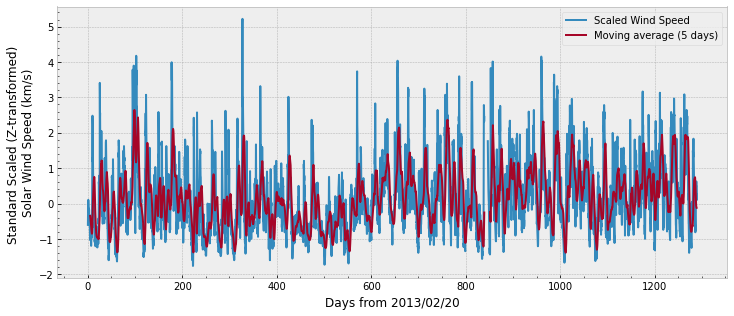

In [22]:
# plot OMNI with specific aesthetics:
with plt.style.context('bmh'):
    fig, ax = plt.subplots(1, figsize=(12,5))
    ax.plot(df.index.get_level_values('Time'), df['omni'], 
            label='Scaled Wind Speed')
    ax.plot(df.index.get_level_values('Time'), df['omni'].rolling(24).mean(), 
            label='Moving average (5 days)')
    ax.set_ylabel('Standard Scaled (Z-transformed) \nSolar Wind Speed (km/s)')
    ax.set_xlabel('Days from 2013/02/20')
    ax.legend()
    ax.minorticks_on()

And the fluxes through different L-shells and levels of energy:

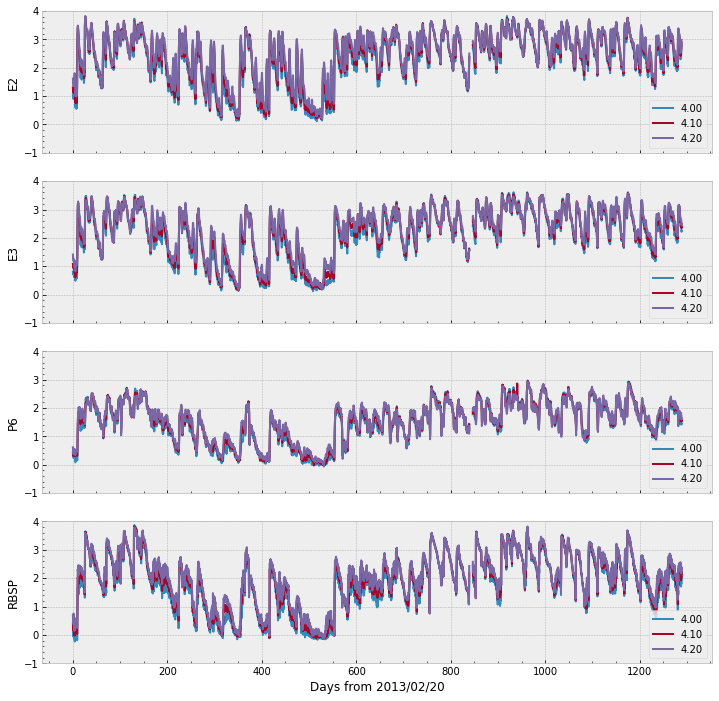

In [23]:
with plt.style.context('bmh'):
    fig, ax = plt.subplots(nrows=4, figsize=(12,12), sharex=True, sharey=True)
    for ii, source in enumerate(['e2', 'e3', 'p6', 'rbsp']):
        df[source].plot(ax=ax[ii]) # Pandas plot function
        ax[ii].minorticks_on()
        ax[ii].set_ylabel(source.upper())
        ax[ii].set_xlabel('')
        ax[ii].legend(loc='lower right')
    ax[-1].set_xlabel('Days from 2013/02/20')
    ax[-1].set_ylim(-1,4)

The figure above show all data scaled within the same range $[-1, 4]$, which is not very far from the range of the omni data as well. 

# 3. Forecasting Relativistic Electrons in Earth's Outer Radiation Belt

[Chen et al. (2019)](https://doi.org/10.1029/2018SW002095) investigated how the variation in population of lower energy electrons $\leq$ 1000 keV preceeds the variation in population of relativistic electrons. Although the physical details on such phenomenon are still under investigation, the basic rationale behind is that the population of electrons in lower energy states are accelerated and become more energetic. Moreover, [Baker et al. (2019)](https://doi.org/10.1029/2018JA026259) showed that solar wind speeds affect MeV electron flux levels, specially at large L-shells. Thus, we use the past values of POES measurements (`e2`, `e3`, `p6`) as well as the solar wind activity (`omni`) to forecast the population of high energy RBSP 1 MeV electrons (`rbsp`). 

The idea of using past values of data $x$ to forecast the target $y$ is expressed by the equation:

\begin{equation}
y_{t+\Delta t}=f(\boldsymbol{x}_{[t-\delta t, t]})
\tag{1}
\end{equation}

 $y_{t+\Delta t}$ in equation (1) 
 is a single scalar value, while $\boldsymbol{x}_{[t- \delta t, t]}$ is a vector containing the past values of $x$ from the time interval $[t-\delta t, t]$ . $f$ is a function that uses the vetor as input and outputs the scalar. 

 Let's "translate" the equations to Python. We can start by shifting the target "to the future". Let $\Delta t = $ `deltat`. As each row in the dataframe `df` represents a five-hour bin value, shifting the data five hours into the future is the equivalent to one day shift:

In [24]:
# print the head of the dataframe before the shift:
df.head(8)

omni        e2            ...      rbsp              set
         SWspeed      4.00      4.10  ...      4.10      4.20       
Time                                  ...                           
0.1875 -0.603239  1.060698  1.305351  ...  0.413300  0.695482  train
0.3958 -0.208945  0.959518  1.206826  ...  0.290035  0.545307  train
0.6042 -0.162558  0.939519  1.181844  ...  0.164353  0.396199  train
0.8125 -0.232139  0.936514  1.155336  ...  0.262451  0.528917  train
1.0208  0.104170  0.933993  1.161368  ...  0.281033  0.540329  train
1.2292  0.069380  0.948902  1.167317  ...  0.260071  0.480007  train
1.4375 -0.023395  0.893762  1.110590  ...  0.378398  0.641474  train
1.6458 -0.185752  0.908485  1.103804  ...  0.555094  0.754348  train

[8 rows x 14 columns]

In [25]:
deltat = 5
df['rbsp'] = df['rbsp'].shift(periods=-deltat)
df.head(8)

omni        e2            ...      rbsp              set
         SWspeed      4.00      4.10  ...      4.10      4.20       
Time                                  ...                           
0.1875 -0.603239  1.060698  1.305351  ...  0.260071  0.480007  train
0.3958 -0.208945  0.959518  1.206826  ...  0.378398  0.641474  train
0.6042 -0.162558  0.939519  1.181844  ...  0.555094  0.754348  train
0.8125 -0.232139  0.936514  1.155336  ...  0.271842  0.477121  train
1.0208  0.104170  0.933993  1.161368  ...  0.155336  0.372912  train
1.2292  0.069380  0.948902  1.167317  ...  0.184691  0.342423  train
1.4375 -0.023395  0.893762  1.110590  ...  0.170262  0.359835  train
1.6458 -0.185752  0.908485  1.103804  ...  0.204120  0.463893  train

[8 rows x 14 columns]

Now, if we select one time bin, the `rbsp` target columns will contain values referent to the future. The previous cell prints the inputs and outputs we need to assemble $y_{t+\Delta t}=f(\boldsymbol{x}_{[t]})$. For example, the row at `Time` 0.1875 contains the input values (`omni`, `e2`, `e3`, `p6`) at their original `Time` 0.1875, however the values of the target (`rbsp`) are the values originally at `Time`  1.2292. 

We want not only to use the input data at a single time $t$, but to use a range $[t - \delta t, t]$. We want to have, for each row, the values of the input at ´Time´$=[t, t-1, t-2, ..., t-\delta t]$. Let $\delta t =$ `window`:

In [26]:
window = 4
# let's use omni as an example of what we are trying to accomplish:
df['omni'].head(8)

SWspeed
Time            
0.1875 -0.603239
0.3958 -0.208945
0.6042 -0.162558
0.8125 -0.232139
1.0208  0.104170
1.2292  0.069380
1.4375 -0.023395
1.6458 -0.185752

In [27]:
# omni has only one feture data:
colname = 'SWspeed'
# we want to have the values of the previous 1, 2, ..., window time steps
for time_shift in range(window):
    df['omni', f'{colname}_tm{time_shift+1}'] = df['omni'][f'{colname}'].shift(periods=time_shift+1)
# display the omni (input) and the rbsp (target) data
df[['omni', 'rbsp']].head(10)

omni                          ...      rbsp                    
         SWspeed SWspeed_tm1 SWspeed_tm2  ...      4.00      4.10      4.20
Time                                      ...                              
0.1875 -0.603239         NaN         NaN  ...  0.056905  0.260071  0.480007
0.3958 -0.208945   -0.603239         NaN  ...  0.206826  0.378398  0.641474
0.6042 -0.162558   -0.208945   -0.603239  ...  0.130334  0.555094  0.754348
0.8125 -0.232139   -0.162558   -0.208945  ...  0.053078  0.271842  0.477121
1.0208  0.104170   -0.232139   -0.162558  ... -0.038105  0.155336  0.372912
1.2292  0.069380    0.104170   -0.232139  ... -0.064997  0.184691  0.342423
1.4375 -0.023395    0.069380    0.104170  ... -0.024109  0.170262  0.359835
1.6458 -0.185752   -0.023395    0.069380  ...  0.008600  0.204120  0.463893
1.8542 -0.139364   -0.185752   -0.023395  ... -0.097453  0.064458  0.290035
2.0625 -0.162558   -0.139364   -0.185752  ... -0.135489 -0.015923  0.146128

[10 rows x 8 columns]

To consider what we accomplished while shifting the data, let's evaluate a single row of the `dataframe` printed above. 

At `Time` 1.0208, we have the values of solar wind speed (`SWspeed`) at time $t = 0.104170, t-1 = -0.232139, ..., t-\delta t = -0.603239$. We chose to append the column name with an indicator for the past values, `tm` as equivalent to $t$ minus. We also have the value for the target `rbsp` **in the future** $t + \Delta t$ at different L-shells, for example $-0.087739$ at L-shell 4.00. Therefore, we can assemble the input $x_{[t, t-\delta t]}$ and the output $y_{t+\Delta t}$ from equation (1) with the values for each one of the rows of the `dataframe`. 

We also want the past values of `e2`, `e3`, and `p6`, let's compute them in a loop in the following cell:


In [28]:
for source in ['e2', 'e3', 'p6']:
    for colname in df[source].columns:
        # we want to have the values of the previous 1, 2, ..., window time steps
        for time_shift in range(window):
            df[source, f'{colname}_tm{time_shift+1}'] = df[source][f'{colname}'].shift(periods=time_shift+1)
# we can sort the index for display purposes
df = df.sort_index(axis=1)

All these shifts create spaces without information in the data. That is reasonable, as the `Time` row at 0.1875	will not have information about the previous measurements to populate values at $[t-1, t-2, ..., t-\delta t]$. We can see the effect of the shifts by generating a figure that shows the `Null` values again:

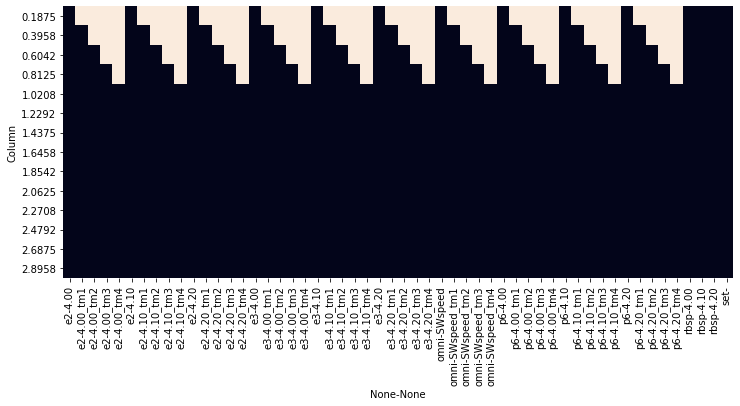

In [29]:
fig, ax = plt.subplots(1, figsize=(12,5))
sns.heatmap(df.loc[0:3].isnull(), cbar=False, ax=ax)
ax.set_ylabel('Column');

We can also selects few days and plot the lines to observe what they look like when shifted:

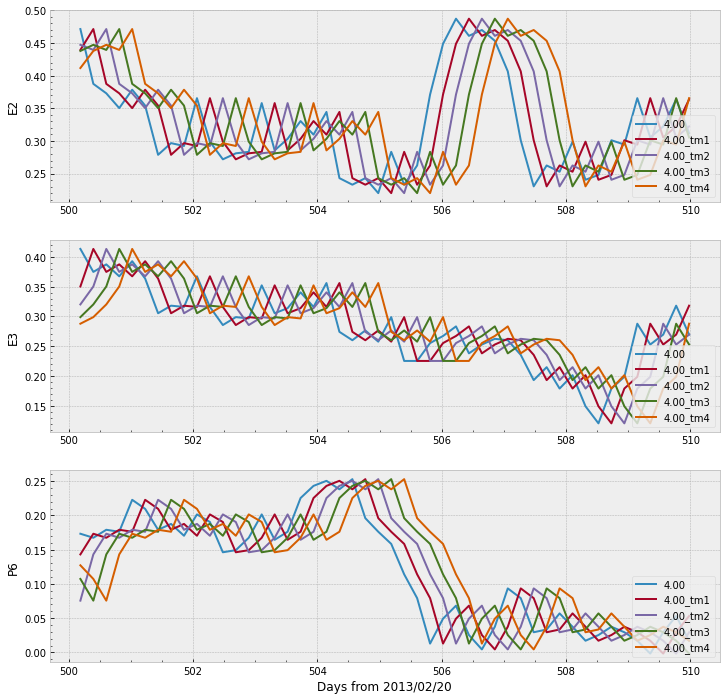

In [30]:
start_day = 500
end_day = 510
lshell = '4.00'
with plt.style.context('bmh'):
    fig, ax = plt.subplots(nrows=3, figsize=(12,12))
    for ii, source in enumerate(['e2', 'e3', 'p6']):
        # we select part of the data, depending on the selected lshell above
        df.loc[start_day:end_day, source][[col for col in df[source].columns 
                                 if lshell in col]].plot(ax=ax[ii]) 
        ax[ii].minorticks_on()
        ax[ii].set_ylabel(source.upper())
        ax[ii].set_xlabel('')
        ax[ii].legend(loc='lower right')
    ax[-1].set_xlabel('Days from 2013/02/20')

For the sake of readability and to facilitate further processing, let's split the dataframe `df` into three different dataframes according to the set, and let's remove the rows containing `Null` values of the new datasets

In [31]:
df_train = df.loc[df['set'] == 'train'].copy()
df_val = df.loc[df['set'] == 'val'].copy()
df_test = df.loc[df['set'] == 'test'].copy()

print(f'Original dataframe contains   {df.shape[0]:4} rows and {df.shape[1]} cols')
print(f'Training dataframe contains   {df_train.shape[0]:4} rows and {df_train.shape[1]} cols')
print(f'Validation dataframe contains {df_val.shape[0]:4} rows and {df_val.shape[1]} cols')
print(f'Test dataframe contains       {df_test.shape[0]:4} rows and {df_test.shape[1]} cols')

print('\nAfter dropping Null values:')
for new_df, set_name in zip([df_train, df_val, df_test], ['Training', 'Validation', 'Test']):
    new_df.dropna(axis=0, how='any', inplace=True)
    print(f'{set_name:15} {new_df.shape[0]:4} rows and {new_df.shape[1]:3} cols')


Original dataframe contains   6187 rows and 54 cols
Training dataframe contains   4029 rows and 54 cols
Validation dataframe contains  976 rows and 54 cols
Test dataframe contains       1147 rows and 54 cols

After dropping Null values:
Training        4020 rows and  54 cols
Validation       972 rows and  54 cols
Test            1142 rows and  54 cols


# 4. Supervised Learning Models

Machine learning is a collection of techniques in which systems improve their performance through automatic analysis of data. The power of machine learning models lies in their capacity to extract statistical information from the data withouth a pre-estabilshed hypothesis, which is a contrast to physics‐based models. Machine learning models are capable of extracting signature and correspondence that might be overlooked by traditional methods, for example, nonlinear relationship, and can be relatively easy to use with multiple input sources. Therefore, under certain circumstances, ML models can outperform traditional ones ([Pires de Lima et al., 2020](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019SW002399)). 

The algorithms used here fall under the category of supervised learning as they make use of input sample data paired with an appropriate label. The label here refers to 1‐MeV electron flux at different L‐shells, the target value to be forecasted. Moreover, the models implemented here can be classified as regressions, as the labels are specified scalar values.

As explained by [Camporeale (2019)](https://doi.org/10.1029/2018SW002061), supervised regressors try to find the mapping relationship between a set of multidimensional inputs $x = (x_1, x_2, …, x_N)$ and its corresponding scalar output label $y$, under the general form
\begin{equation}
y=f(\boldsymbol{x}+\epsilon)
\tag{2}
\end{equation}

where $f : \mathbb{R}^{N} \rightarrow \mathbb{R}$ is a linear or nonlinear function and $\epsilon$ represents additive noise that inevitably contaminates either the data or the model. All methods used to find the unknown function $f$ can be seen as an optimization problem where the objective is to minimize a given loss function. The loss function is a function that maps the distance between all the predicted and target values into a real number, therefore providing some “cost” associated with the prediction. 

One of the most common metrics to evaluate the performance of regressors is the [$R^2$](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) score. This metric is computed with the same equation as the performance efficiency (PE), with the form of use as the primary difference between both. The equation for PE is given by:

\begin{equation}
PE=1 - \frac{\sum(y_i-fi)^2}{\sum(y_i-\bar{y})^2}
\tag{3}
\end{equation}

where the sum spans all $i$ elements, $y_i$ is the value $y$ at $i$, $f_i$ is the predicted (or forecasted) value at $i$, and $\bar{y}$ is the mean of the observations over all $i$. PE have a maximum value of 1.00 when the prediction $f$ is equal to the data $y$. PE is equal to zero if the prediction $f$ is equivalent to the mean $\bar{y}$. Technically PE has no lower bound, meaning the prediction $f$ can be worst than the mean. 


## 4.1 Linear Regression

Over the past sections, we have prepared the data in a format that is very convenient to be used for most machine learning libraries. We now can finally work towards finding the function $f$ that maps the inputs to the targets. We start with the simple, yet valuable, linear model. We use [Scikit-Learn's](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) Ordinary Least Squares (OLS) regression. We start by instantiating an OLS reggresion object:

In [32]:
reg = LinearRegression()

`reg` object has methods to perform the optimization and find the best fit following the OLS algorithm. The method `fit` expects the inputs `X` with dimensions (rows, columns) and `y` with dimensions (rows, 1). After all the preparation in the previous sections, wecan easily select these elements from our `dataframes`. [Pires de Lima et al. (2020)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019SW002399) searched for different combinations of `e2`, `e3`, `p6`, and `omni` and found that the performance of the models increased as the number of input features increased, in other words, using more explanatory variables helped the model in the prediction. Let's start by making the forecast of 1 MeV electrons of a single L-shell using only `e2` as input:

In [33]:
lshell = '4.00'
# we need to select the 'current' time
cols = [lshell] 
# as well as the past values
cols = cols + ([f'{lshell}_tm{t}' for t in range(1, window+1)]) 
# we select from the training data only:
X = df_train['e2'][cols].to_numpy()
y = df_train['rbsp'][lshell]
# fit the model:
reg.fit(X, y)
# print the score in the training data:
print(f'Training PE     = {reg.score(X, y):.2f}')
# which is the same as comparing the true measure values with
# the predicted values:
y_pred = reg.predict(X)
print(f'True vs pred PE = {r2_score(y, y_pred):.2f}')
# we should also verify the performance on the validation data:
X_val = df_val['e2'][cols].to_numpy()
y_val = df_val['rbsp'][lshell]
y_pred_val = reg.predict(X_val)
print(f'Validation PE   = {r2_score(y_val, y_pred_val):.2f}')

Training PE     = 0.70
True vs pred PE = 0.70
Validation PE   = 0.43


The PE values for both train and validation sets show that the model is able to predict the data and that there is room for improvement. There is some overfitting as the performance is better on the training set than on the validation set. Note that we are not using the test for now, ideally it will be used only on the final stages.  

Let's see a plot for the predictions:

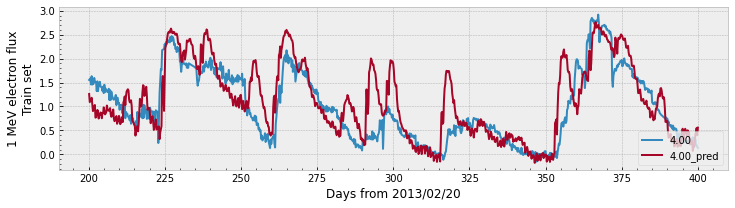

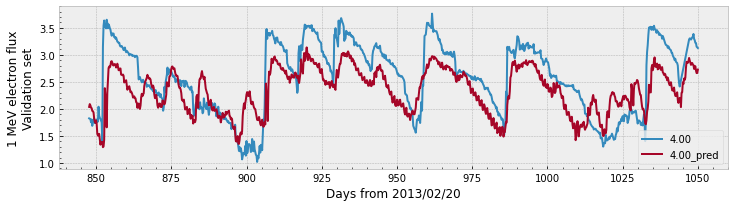

In [34]:
# let's also plot a few days of the training set 
# to compare the prediction and the measured data:
df_train[f'{lshell}_pred'] = y_pred
start_day = 200
end_day = 400
with plt.style.context('bmh'):
    fig, ax = plt.subplots(nrows=1, figsize=(12,3))
    # we select part of the data, depending on the selected lshell above
    df_train.loc[start_day:end_day, 'rbsp'][lshell].plot(ax=ax) 
    df_train.loc[start_day:end_day, f'{lshell}_pred'].plot(ax=ax) 
    ax.minorticks_on()
    ax.set_ylabel('1 MeV electron flux\nTrain set')
    ax.set_xlabel('')
    ax.legend(loc='lower right')
    ax.set_xlabel('Days from 2013/02/20')
fig.show()    
df_val[f'{lshell}_pred'] = y_pred_val
# the same for the validation set:
with plt.style.context('bmh'):
    fig, ax = plt.subplots(nrows=1, figsize=(12,3))
    # we select part of the data, depending on the selected lshell above
    df_val.loc[:, 'rbsp'][lshell].plot(ax=ax) 
    df_val.loc[:, f'{lshell}_pred'].plot(ax=ax) 
    ax.minorticks_on()
    ax.set_ylabel('1 MeV electron flux\nValidation set')
    ax.legend(loc='lower right')
    ax.set_xlabel('Days from 2013/02/20')
fig.show()    

Both plots show that the prediction follows the general trend of the measured data. The validation plot shows a larger gap between the values of the prediction compared to the data, which explains the lower PE value.

Let's see how the linear model performs using data from all sources and let's forecast for all available L-shells:

In [35]:
# we are going to select all sources:
sources = ['omni', 'e2', 'e3', 'p6']

# we need to select the 'current' time of omni
cols_initial = ['SWspeed'] 
# as well as omni's past values
cols_initial = cols_initial + ([f'SWspeed_tm{t}' for t in range(1, window+1)]) 

# print a "header" for the table the loop will generate:
print(f"{'Lshell':>10} {'Train PE':>10} {'Validation PE':>15}")

# loop through all the L-shells we wish to compute:
for lshell in ['4.00', '4.10', '4.20']:
    # we need to select the 'current' time
    cols = cols_initial + [lshell] 
    # as well as the past values
    cols = cols + ([f'{lshell}_tm{t}' for t in range(1, window+1)])

    # we select from the training data only:
    X = df_train.loc[:, (sources,cols)].to_numpy()
    y = df_train['rbsp'][lshell]
    # fit the model:
    reg.fit(X, y)
    # the predicted values:
    y_pred = reg.predict(X)
    # compute the score in the training data:
    pe_train = r2_score(y, y_pred)
    # we should also verify the performance on the validation data:
    X_val = df_val.loc[:, (sources,cols)].to_numpy()
    y_val = df_val['rbsp'][lshell]
    y_pred_val = reg.predict(X_val)
    pe_val = r2_score(y_val, y_pred_val)
    print(f'{lshell:>10} {pe_train:>10.2f} {pe_val:>15.2f}')

    # after fitting the model on the train data, 
    # we can actually predict the values for the whole original dataframe.
    # However, scikit-learn does not compute on Null values, so we fill them:
    X_all = df.loc[:, (sources,cols)].fillna(-1e10).to_numpy()
    y_pred_all = reg.predict(X_all)
    df.loc[:, ('linear', lshell)] = y_pred_all
    # remember to populate Null predictions with Null values:
    df.loc[df.isnull().any(axis=1), ('linear', lshell)] = np.nan

    Lshell   Train PE   Validation PE
      4.00       0.91            0.69
      4.10       0.90            0.65
      4.20       0.89            0.61


There still seems to be some overfitting, but the model greatly improved the performance for both the training set as the validation set. The increase in performance is an indication that the extra explanatory variables are helping in the forecast. Both [Chen et al. (2019)](https://doi.org/10.1029/2018SW002095) and [Pires de Lima et al. (2020)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019SW002399) found that there is a strong linear component in the relationship between relativistic electrons and lower energy electrons in Earth's outer radiation belt. 

This might be a good place to have an interactive plot. In the next cell, we melt the dataframe, mantaining only the `rbsp` target values and the predicted `linear` data. The tools can be used to change L-shell, pan, and zoom around to see how the model is performing.



In [36]:
melted_df = df.loc[:,['rbsp', 'linear']].reset_index().melt(id_vars='Time', var_name = ['source', 'L-shell'])
fig = px.line(melted_df, x='Time', y='value', color='source', animation_frame='L-shell')
fig.show()

## 4.2 Convolutional Neural Networks

We already obtained promising results for the forecasting of 1 MeV electrons using a simple linear model. [Pires de Lima et al. (2020)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019SW002399) investigated the use of deep learning architectures for the forecasting task, including feedforward artificial neural networks, networks with long-short term memory (LSTM) units, and convolutional neural networks (CNN). To explore deep learning models, we will assemble a CNN for the forecast of 1 MeV electrons in Earth's outer radiation belt using the same input as the linear regression model from the previous section. 

CNNs a very popular architecture used in many applications. The CNN described in [Krizhevsky et al. (2012)](https://dl.acm.org/doi/10.5555/2999134.2999257) achieved new levels of accuracy in the popular ImageNet Large Scale Visual Recognition Competition ([Russakovsky et al., 2015](https://link.springer.com/article/10.1007/s11263-015-0816-y)) and led the computer vision research to widely adopt the architecture. Despite several different details, all CNNs make use of the fundamental convolutional kernel. The convolution function operates on two signals, one generally interpreted as the "input", and the other as a "filter". The filter is applied on the input, producing an output image or signal. The non-linearity of CNNs are defined by the activation function that is applied on the ouput. During the training stage, the values of kernels are updated in such a way that the output generated by the CNN is more similar to the desired label, that is, minimizes the loss. 

[Scikit-learn](https://scikit-learn.org/stable/index.html) contains a [module](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.neural_network) that implements feedforward neural networks, but for more complex architectures such as CNNs researchers usually choose between [TensorFlow](https://www.tensorflow.org/) or [PyTorch](https://pytorch.org/). We will use [TensorFlow](https://tensorflow.org/) in this notebook. We need to consider the input shape (`X` and `y` used in the previous section) as well as the desired network architecture. We select [Adam](https://arxiv.org/abs/1412.6980) as the optimizer that will reduce the Mean Squared Error (MSE) loss through backpropagation. 

In [37]:
# We first define the model
model = tf.keras.Sequential([
    # The input for the model is X defined before. 
    # We consider X as a single channel input
    # with 20 elements: 4 sources * (current time + 4 past times)                             
    # thus the input_shape = [50, 1]
    tf.keras.layers.Conv1D(filters=64,
                           kernel_size=3,
                           activation='elu', 
                           input_shape=[20, 1]),
    tf.keras.layers.MaxPool1D(),       
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=3,
                           activation='elu'),
    tf.keras.layers.MaxPool1D(),       
    tf.keras.layers.Flatten(),                        
    tf.keras.layers.Dense(units=1),
])

# then compile it using a Mean Squared Error (MSE) loss and Adam optimizer
model.compile(optimizer='adam',
              loss=tf.keras.losses.MSE)

# print the model summary:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 18, 64)            256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 9, 64)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7, 32)             6176      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 32)             0         
_________________________________________________________________
flatten (Flatten)            (None, 96)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 97        
Total params: 6,529
Trainable params: 6,529
Non-trainable params: 0
______________________________________________________

Similar to what we did for the linear regression, the next step is to define the inputs and outputs for the TensorFlow model. Unlike [Scikit-Learn's](https://scikit-learn.org/) models that expect the inputs `X` to have dimensions (rows, columns) and `y` to have dimensions (rows, 1), the [TensorFlow](https://tensorflow.org/) model we created expects `X` to have dimensions of (batch, rows, channels). In this experiment, we are considering the data has a single channel for all different input sources. 

In [38]:
lshell = '4.00'
# we need to select the 'current' time
cols = cols_initial + [lshell] 
# as well as the past values
cols = cols + ([f'{lshell}_tm{t}' for t in range(1, window+1)]) 

# we train with data from the training dataframe:
X = df_train.loc[:, (sources,cols)].to_numpy()
y = df_train['rbsp'][lshell]

# we should also verify the performance on the validation data:
X_val = df_val.loc[:, (sources,cols)].to_numpy()
y_val = df_val['rbsp'][lshell]

# the input for TensorFlow is slightly different than the ones we use for
# sklearn models. 
# TensorFlow expects the last dimension to be the number of channels, 
# so we modify the shape of the numpy array with np.expand_dims
# now we prepare the data for the TensorFlow model:
train_dataset = tf.data.Dataset.from_tensor_slices((np.expand_dims(X, axis=-1), y))
val_dataset = tf.data.Dataset.from_tensor_slices((np.expand_dims(X_val, axis=-1), y_val))
# TensorFlow processes the models in batches (small chunks of data)
batch_size = 1024
# it is good practice to shuffle the training data
shuffle_buffer_size = len(y)

# finally, the train and validation TensorFlow datasets can be setup
train_dataset = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

After preparing the data, we can now fit the model for a number of epochs. An epoch is a whole pass through the data (using all batches):

In [39]:
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=100)

Epoch 1/100
4/4 [==============================] - 0s 60ms/step - loss: 2.0060 - val_loss: 1.6359
Epoch 2/100
4/4 [==============================] - 0s 24ms/step - loss: 0.4203 - val_loss: 0.2357
Epoch 3/100
4/4 [==============================] - 0s 25ms/step - loss: 0.4385 - val_loss: 0.3472
Epoch 4/100
4/4 [==============================] - 0s 24ms/step - loss: 0.5225 - val_loss: 0.2370
Epoch 5/100
4/4 [==============================] - 0s 23ms/step - loss: 0.3139 - val_loss: 0.2490
Epoch 6/100
4/4 [==============================] - 0s 24ms/step - loss: 0.2342 - val_loss: 0.4664
Epoch 7/100
4/4 [==============================] - 0s 26ms/step - loss: 0.2725 - val_loss: 0.5299
Epoch 8/100
4/4 [==============================] - 0s 24ms/step - loss: 0.2617 - val_loss: 0.3859
Epoch 9/100
4/4 [==============================] - 0s 24ms/step - loss: 0.2136 - val_loss: 0.2489
Epoch 10/100
4/4 [==============================] - 0s 26ms/step - loss: 0.2034 - val_loss: 0.2012
Epoch 11/100
4/4 [=

After training, we can plot the training and validation loss to see how the model improved its performance over time:

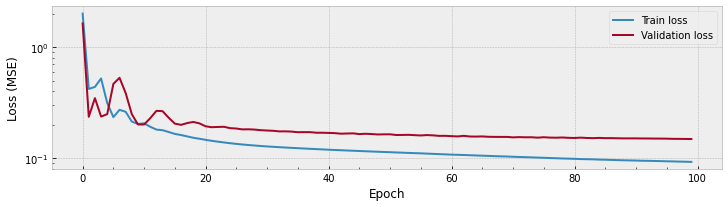

In [40]:
with plt.style.context('bmh'):
    fig, ax = plt.subplots(nrows=1, figsize=(12,3))
    ax.plot(history.history['loss'], label='Train loss')
    ax.plot(history.history['val_loss'], label='Validation loss')
    ax.minorticks_on()
    ax.set_ylabel('Loss (MSE)')
    ax.set_xlabel('Epoch')
    ax.legend(loc='upper right')
    ax.set_yscale('log')
fig.show()    

The plot above shows there is a great improvement in the train data at the first $\sim$ 10 epochs, and steady small improvements after that. The validation performance sems to get stable after $\sim$ 25 epochs or so. 

Let's compare the prediction with the real measured data:

Train PE        = 0.90
Validation PE   = 0.65


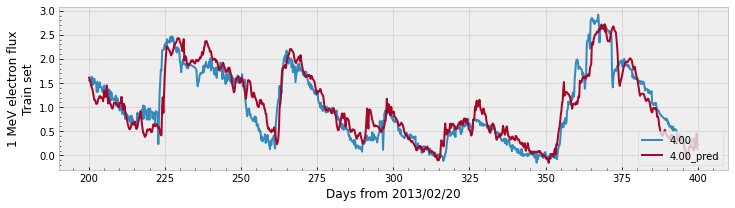

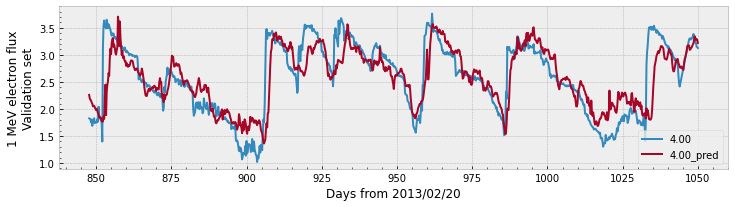

In [41]:
y_pred = model.predict(np.expand_dims(X, axis=-1))
y_pred_val = model.predict(np.expand_dims(X_val, axis=-1))
# to compare the prediction and the measured data:
df_train[f'{lshell}_pred'] = y_pred
start_day = 200
end_day = 400
with plt.style.context('bmh'):
    fig, ax = plt.subplots(nrows=1, figsize=(12,3))
    # we select part of the data, depending on the selected lshell above
    df_train.loc[start_day:end_day, 'rbsp'][lshell].plot(ax=ax) 
    df_train.loc[start_day:end_day, f'{lshell}_pred'].plot(ax=ax) 
    ax.minorticks_on()
    ax.set_ylabel('1 MeV electron flux\nTrain set')
    ax.set_xlabel('')
    ax.legend(loc='lower right')
    ax.set_xlabel('Days from 2013/02/20')
fig.show()    
df_val[f'{lshell}_pred'] = y_pred_val
# the same for the validation set:
with plt.style.context('bmh'):
    fig, ax = plt.subplots(nrows=1, figsize=(12,3))
    # we select part of the data, depending on the selected lshell above
    df_val.loc[:, 'rbsp'][lshell].plot(ax=ax) 
    df_val.loc[:, f'{lshell}_pred'].plot(ax=ax) 
    ax.minorticks_on()
    ax.set_ylabel('1 MeV electron flux\nValidation set')
    ax.legend(loc='lower right')
    ax.set_xlabel('Days from 2013/02/20')
fig.show() 

print(f'Train PE        = {r2_score(y, y_pred):.2f}')
print(f'Validation PE   = {r2_score(y_val, y_pred_val):.2f}')

As a recap, in the previous cells we:

1.   Created a convolutional neural network model with TensorFlow;
2.   Compiled the TensorFlow model;
3.   Selected and prepared the data from the dataframes as input to the model;
4.   Fitted the model;
5.   Compared the predictions of the model with the target data. 

The whole experiment was conducted for a single L-shell. We can do something similar to what we did with linear models to forecast using the CNN for the remaining L-shells. However, we cannot call `model.fit` like we did for linear regression, that would simply continue to fit the model that was already trained. As what we are trying to accomplish is not very computationally expensive, we can get away by re-creating the model at each iteration:

In [42]:
# we are going to select all sources:
sources = ['omni', 'e2', 'e3', 'p6']

# we need to select the 'current' time of omni
cols_initial = ['SWspeed'] 
# as well as omni's past values
cols_initial = cols_initial + ([f'SWspeed_tm{t}' for t in range(1, window+1)]) 

# TensorFlow processes the models in batches (small chunks of data)
batch_size = 1024
# it is good practice to shuffle the training data
shuffle_buffer_size = len(y)

# let's save the training history in a dictionary in case we wish to inspect it:
hist = {}

# print a "header" for the table the loop will generate:
print(f"{'Lshell':>10} {'Train PE':>10} {'Validation PE':>15}")

# loop through all the L-shells we wish to compute:
for lshell in ['4.00', '4.10', '4.20']:
    # `clear_session()` so Keras starts with a blank state at each iteration
    # and memory consumption is constant over time.
    tf.keras.backend.clear_session()
    ##################################
    # model preparation
    ##################################
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters=64,
                            kernel_size=3,
                            activation='elu', 
                            input_shape=[20, 1]),
        tf.keras.layers.MaxPool1D(),       
        tf.keras.layers.Conv1D(filters=32,
                            kernel_size=3,
                            activation='elu'),
        tf.keras.layers.MaxPool1D(),       
        tf.keras.layers.Flatten(),                        
        tf.keras.layers.Dense(units=1),
    ])
    model.compile(optimizer='adam',
                loss=tf.keras.losses.MSE)
    ##################################
    # data preparation
    ##################################
    # we need to select the 'current' time together with omni
    cols = cols_initial + [lshell] 
    # as well as the past values
    cols = cols + ([f'{lshell}_tm{t}' for t in range(1, window+1)])

    # we train with data from the training dataframe:
    X = df_train.loc[:, (sources,cols)].to_numpy()
    y = df_train['rbsp'][lshell]

    # we should also verify the performance on the validation data:
    X_val = df_val.loc[:, (sources,cols)].to_numpy()
    y_val = df_val['rbsp'][lshell]

    # set up the input
    train_dataset = tf.data.Dataset.from_tensor_slices((np.expand_dims(X, axis=-1), y))
    val_dataset = tf.data.Dataset.from_tensor_slices((np.expand_dims(X_val, axis=-1), y_val))

    # finally, the train and validation TensorFlow datasets can be setup
    train_dataset = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size)
    val_dataset = val_dataset.batch(batch_size)

    ##################################
    # model fit
    ##################################
    hist[lshell] = model.fit(train_dataset,
                             validation_data=val_dataset,
                             epochs=100,
                             verbose=0 # the model trains fast, no need to print
                             )
    ##################################
    # model prediction 
    ##################################
    y_pred = model.predict(np.expand_dims(X, axis=-1))
    y_pred_val = model.predict(np.expand_dims(X_val, axis=-1))

    # after fitting the model on the train data, 
    # we can actually predict the values for the whole original dataframe.
    X_all = df.loc[:, (sources,cols)].to_numpy()
    y_pred_all = model.predict(np.expand_dims(X_all, axis=-1))
    df.loc[:, ('CNN', lshell)] = y_pred_all
    # remember to populate Null predictions with Null values:
    df.loc[df.isnull().any(axis=1), ('linear', lshell)] = np.nan

    ##################################
    # training performance
    ##################################
    pe_train = r2_score(y, y_pred)
    pe_val = r2_score(y_val, y_pred_val)
    print(f'{lshell:>10} {pe_train:>10.2f} {pe_val:>15.2f}')

    Lshell   Train PE   Validation PE
      4.00       0.90            0.66
      4.10       0.89            0.63
      4.20       0.89            0.59


We again observe some overfitting and actually see results comparable to the linear model. 

We now use an interactive plot again. In the next cell, we melt the dataframe, mantaining only the `rbsp` target values and the predicted `linear` and `CNN` data. The tools can be used to change L-shell, pan, and zoom around to see how the model is performing.

In [43]:
melted_df = df.loc[:,['rbsp', 'linear', 'CNN']].reset_index().melt(id_vars='Time', var_name = ['source', 'L-shell'])
fig = px.line(melted_df, x='Time', y='value', color='source', animation_frame='L-shell')
fig.show()

## 4.3 Comparison
 
 We now got to the final stages of this analysis. We fitted two different models in the data and saved the results in the bigger dataframe `df` that contains all of the data we used. We can now compare `linear` vs `CNN` model in all the sets, accros all L-shells. 

Let's split the `df` again and overwrite the `df_train`, `df_val`, and `df_test` as now `df` also contains the predictions. We also ignore the Null values:

In [44]:
df_train = df.loc[df['set'] == 'train'].copy().dropna()
df_val   = df.loc[df['set'] == 'val'].copy().dropna()
df_test  = df.loc[df['set'] == 'test'].copy().dropna()

Let's compute the PE accross all sets and all L-shells:

In [45]:
# print a "header" for the table the loop will generate:
print(f"{'Set':>12} {'Linear PE':>12} {'CNN PE':>12}")
for dset, nset in zip([df_train, df_val, df_test],['Train', 'Validation', 'Test']):
    y_true = dset['rbsp'].to_numpy().ravel()
    y_linear = dset['linear'].to_numpy().ravel()
    y_cnn = dset['CNN'].to_numpy().ravel()

    pe_linear = r2_score(y_true, y_linear)
    pe_cnn = r2_score(y_true, y_cnn)

    print(f'{nset:>12} {pe_linear:>12.2f} {pe_cnn:>12.2f}')

         Set    Linear PE       CNN PE
       Train         0.90         0.90
  Validation         0.66         0.63
        Test         0.68         0.69


There seems to be some overfitting for both models as the performance in the train set is better than the performance in the validation and test sets. The PE for the linear model is better in the validation set than the CNN, however CNN is slightly better in the test set. 

The metrics and the shell-by-shell interactive plots help us understand the relationship of the predictions with the target data. Another valuable graphical alternative to show such relationship is to plot the true values versus the predicted values. The relationship can be expressed with a scatter plot, however a 2D histogram might be more revealling for cases in which there are many points to be analyzed. 

bin x size = 0.10, bin y size = 0.10


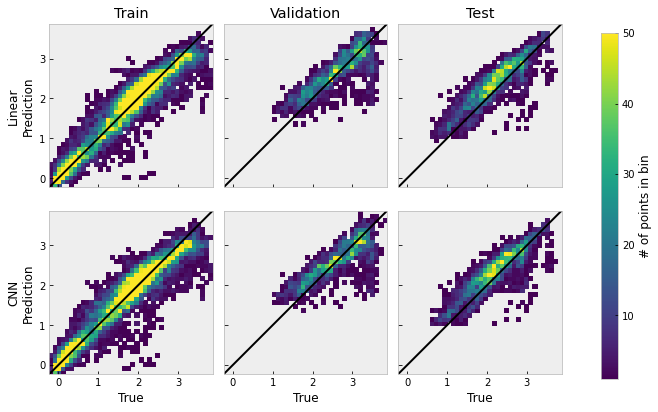

In [46]:
ymin = df['rbsp'].dropna().min().min()
ymax = df['rbsp'].dropna().max().max()
with plt.style.context('bmh'):
    fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(8,6))
    col = 0 # to help position plots
    for dset, nset in zip([df_train, df_val, df_test],['Train', 'Validation', 'Test']):
        y_true = dset['rbsp'].to_numpy().ravel()
        y_linear = dset['linear'].to_numpy().ravel()
        y_cnn = dset['CNN'].to_numpy().ravel()

        h = ax[0,col].hist2d(y_true, y_linear, 
                           bins=40, range=[[ymin, ymax], [ymin, ymax]],
                           cmin=1., vmax=50)

        h = ax[1,col].hist2d(y_true, y_cnn, 
                           bins=40, range=[[ymin, ymax], [ymin, ymax]],
                           cmin=1., vmax=50)
        ax[0, col].plot([ymin, ymax], [ymin, ymax], c='k')        
        ax[1, col].plot([ymin, ymax], [ymin, ymax], c='k')        

        ax[0,col].set_aspect('equal')
        ax[1,col].set_aspect('equal')

        ax[-1, col].set_xlabel('True')
        ax[0, col].set_title(nset)        
        col+=1
    ax[0,0].set_ylabel('Linear\nPrediction')
    ax[1,0].set_ylabel('CNN\nPrediction')

    fig.tight_layout()
    cbar_ax = fig.add_axes([1.05, 0.1, 0.03, 0.8])
    cbar = fig.colorbar(h[3], cax=cbar_ax)
    cbar.ax.set_ylabel('# of points in bin')

    fig.show()

    # you can get the bin size by the return from h
    binx = h[1][1] - h[1][0]
    biny = h[2][1] - h[2][0]
    print(f'bin x size = {binx:.2f}, bin y size = {biny:.2f}')

In the figure above, we set the lower limit to 1, so bins with zero occurrences appear white, and we set the higher limit to 50, so bins with 50 or more points appear yellow. The image shows that the training data actually spans wider than the validation and test sets, having more small flux values close to zero. Distributions in all plots stay close to the diagnoal indicating unit ratio between the forecast and the true data, which shows that both models are capable of modeling the general trend of the data. However, there are some consisent underpredictions for the higher values of the true data in the validation and test sets.  

# 5. Final Remarks

In this notebook, we examined how 1 MeV electrons inside Earth's outer radiation belt can be forecasted with supervised machine learning models. The input for such models are lower energy electrons ($\leq$ 1000 eV) as well as solar wind speed data. We divided a pre-processed five-hour binned data into train, validation, and test set and we were able to forecast the general dynamics of 1 MeV electrons. Here is a list of topics that can be further evaluated in the future:

*   We are considering the data has a single channel for all different input sources for the CNN model. Perhaps a more sensitive choice would be to have each input as an independent channel. 
*   We did not investigate how much the past values of the input affect the forecast (the `window` variable). Both [Chen et al. (2019)](https://doi.org/10.1029/2018SW002095) and [Pires de Lima et al. (2020)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019SW002399) briefly disccussed how the correlation decays with longer periods.
*   We did not explore number of layers and number of filters, as well as different neural network architectures, or other supervised learning techniques. [Pires de Lima et al. (2020)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019SW002399) present a more complete picture with several different models. 
*   We did not explore cross-shell correlation and how that could affect the forecast. 
*   We did not use k-folds cross-validation here, mainly due to the `Null` section of the data. k-folds cross-validation might help understand how the model performs with unseen data. [Bobra and Ilonidis (2016)](https://ui.adsabs.harvard.edu/abs/2016ApJ...821..127B/abstract) used k-fold cross-validation to evaluate the prediction of coronal mass ejections.
*   Finally, models in this notebook forecasted only one-day (25 hours) ahead (`deltat`). We can try to forecast for two or more days and observe the effects in models' performance. [Pires de Lima et al. (2020)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019SW002399) observed a decay in performance for two-days prediction compared to one-day.  

This notebook was originally executed in [Google's Colaboratory](https://research.google.com/colaboratory/faq.html). CPU information and execution time from the `imports` cell up to this point are given below. The execution time estimate for the full analysis in [Pires de Lima et al. (2020)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019SW002399) is closer to 3 hours. 

In [47]:
end_time = timer()
elapsed = end_time - start_time 
print(f'Notebook execution time: {elapsed:.2f}s ({elapsed/60:.2f} minutes)')
print(f'\nOther cpu information:')
!cat /proc/cpuinfo

Notebook execution time: 73.98s (1.23 minutes)

Other cpu information:
processor	: 0
vendor_id	: AuthenticAMD
cpu family	: 23
model		: 49
model name	: AMD EPYC 7B12
stepping	: 0
microcode	: 0x1000065
cpu MHz		: 2250.000
cache size	: 512 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid extd_apicid tsc_known_freq pni pclmulqdq ssse3 fma cx16 sse4_1 sse4_2 movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm cmp_legacy cr8_legacy abm sse4a misalignsse 3dnowprefetch osvw topoext ssbd ibrs ibpb stibp vmmcall fsgsbase tsc_adjust bmi1 avx2 smep bmi2 rdseed adx smap clflushopt clwb sha_ni xsaveopt xsavec xgetbv1 clzero xsaveerptr arat npt nrip_save umip rdpid
bugs		: sysret_ss_attrs sp

List the version of the libraries used in this notebook:

In [48]:
import matplotlib # import the full library to get version
import plotly     # import the full library to get version
import sklearn    # import the full library to get version

libs = {'numpy': np, 
        'pandas': pd, 
        'matplotlib': matplotlib,
        'seaborn': sns,
        'plotly': plotly,
        'scikit-learn': sklearn, 
        'tensorflow': tf}
print(f'{"Library":20} version')
for k in libs:
    print(f'{k:19}  {libs[k].__version__}')        

Library              version
numpy                1.18.5
pandas               1.0.5
matplotlib           3.2.2
seaborn              0.10.1
plotly               4.4.1
scikit-learn         0.22.2.post1
tensorflow           2.3.0
